# Introdução

Neste projeto iremos abordar o ajuste de redes do tipo Multi Layer Perceptron (MLP), onde iremos abordar dois tipos de datasets: 
 * Regressão;
 * Classificação. 


Para cada dataset regras relacionadas à arquitetura das redes, otimizadores de parâmetros e critérios de avaliação de performance:

 * Serão testadas 5 topologias diferentes;
 * Iremos utilizar a rede com o otimizador original SGD (Stochastic Gradient Descent)
 * Avaliaremos o impacto do uso do Momentum
 * Avaliaremos o impacto do uso da regularização
 * ilustraremos a evolução do ajuste (treino/validação)

Este Notebook foi desenvolvido utilizando a ferramenta de modelagem Keras e a IDE de programação Google Colab na linguagem Python.




In [ ]:
# dados
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Redes Neurais
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Plot
import matplotlib.pyplot as plt
%matplotlib inline
# Avaliação
from sklearn.metrics import classification_report, confusion_matrix



# Classificação


Base de dados astronomicos para identificação de possíveis objetos perigosos nas proximidades da terra utilizando variáveis de diâmetro do objeto, distância entre outros. Os dados estão disponíveis em: (https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects)

## Limpeza e Análise Descritiva dos Dados

In [ ]:
dados_nasa = pd.read_csv("neo_v2.csv")

In [ ]:
dados_nasa.shape

(90836, 10)

In [ ]:
dados_nasa.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


Nossa base completa é composta por 90836 observações e as dez variáveis seguintes:

- id: identificador único do objeto
- name: nome dado pela NASA para o objeto
- est_diameter_min: diâmetro mínimo estimado
- est_diameter_max: diâmetro máximo estimado
- relative_velocity: velocidade relativa com a terra
- miss_distance: distância em quilometros
- orbiting body: planeta que o objeto orbita
- sentry_object: observacao inclusa no sistema de monitoramento de colisão sentry
- absolute_magnitude: descreve a luminosidade intríseca do objeto
- hazardous(variável resposta): booleano que descreve se um objeto é perigoso ou não

In [ ]:
dados_nasa.id.value_counts(dropna = False)

2469219    43
2277810    43
3743123    40
2138175    39
3893865    38
           ..
3768019     1
3774692     1
3779049     1
3775040     1
3092229     1
Name: id, Length: 27423, dtype: int64

In [ ]:
# remoção das colunas de id, name pois sao identificadores do objeto de estudo

dados_nasa.drop(columns = ["id","name"],inplace = True)



In [ ]:
dados_nasa.sentry_object.value_counts(dropna = False)

False    90836
Name: sentry_object, dtype: int64

In [ ]:
dados_nasa.orbiting_body.value_counts(dropna = False)

Earth    90836
Name: orbiting_body, dtype: int64

In [ ]:
# remocao da variaveis sentry_object e orbiting_body pois essa tem apenas um valor na base

dados_nasa.drop(columns = ["sentry_object","orbiting_body"],inplace = True)

In [ ]:
dados_nasa.shape

(90836, 6)

In [ ]:
dados_nasa.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,False
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,True
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,False
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,False
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,True


In [ ]:
# describe das bases para verificação etatisticas de posição
dados_nasa.describe()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


Podemos notar que existe uma certa diferença na escala das variáveis mesmo em cada variável dependendo do objeto temos uma variabilidade alta dos valores.

In [ ]:
dados_nasa.hazardous.value_counts(normalize = True, dropna = False)

False    0.902682
True     0.097318
Name: hazardous, dtype: float64

In [ ]:
dados_nasa.hazardous.value_counts( dropna = False)

False    81996
True      8840
Name: hazardous, dtype: int64

Podemos notar (felizmente) que temos poucos objetos perigosos nas proximidades da terra, no entanto, isso causa um desbalanceamento com relação a variável resposta o que pode causar uma baixa qualidade de ajuste dos modelos. Logo, iremos gerar uma base de treino que seja balanceada, as demais de validação e teste não necessariamente precisam do balanceamento já que serão utilizadas para verificar o ajuste do modelo.

In [ ]:
# separando base de treino e teste
entradas = dados_nasa.drop(columns=["hazardous"])
saida = dados_nasa.loc[:,"hazardous"]

x, x_teste, y, y_teste = train_test_split(entradas,saida,test_size=0.1,train_size=0.9,stratify=saida)

In [ ]:
print(y.value_counts(normalize = True))
print(y_teste.value_counts(normalize = True))

False    0.902681
True     0.097319
Name: hazardous, dtype: float64
False    0.902686
True     0.097314
Name: hazardous, dtype: float64


In [ ]:
# separanda base de treino em treino e validação

x_treino, x_validacao, y_treino, y_validacao = train_test_split(x,y,test_size=0.1,train_size=0.9,stratify=y)

In [ ]:
x_treino.shape

(73576, 5)

In [ ]:
y_treino.value_counts()

False    66416
True      7160
Name: hazardous, dtype: int64

In [ ]:
# undersampling da base de treino para ajuste do modelo com classe balanceadas
x_treino["hazardous"] = y_treino # adicionando o y-treino na base para selecionar as categorias balanceadas
base_falsos = x_treino[x_treino.hazardous == False]
amostra_falsos = base_falsos.sample(7160)
base_verdadeiros = x_treino[x_treino.hazardous == True]
x_treino_undersampled = pd.concat([amostra_falsos,base_verdadeiros],axis=0)

In [ ]:
x_treino_undersampled.shape

(14320, 6)

In [ ]:
x_treino_undersampled.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
40285,0.088015,0.196807,102168.745933,6.239042e+07,22.40,False
87592,0.041358,0.092478,27247.343571,2.402686e+07,24.04,False
33339,0.096506,0.215794,51394.163590,4.262667e+07,22.20,False
13765,0.060891,0.136157,36772.031318,5.030243e+07,23.20,False
46642,0.006089,0.013616,50585.340842,3.515881e+07,28.20,False


In [ ]:
x_treino_undersampled.hazardous.value_counts()

False    7160
True     7160
Name: hazardous, dtype: int64

In [ ]:
# separando base de treino em x e y novamente

x_treino = x_treino_undersampled.drop(columns=["hazardous"])
y_treino = x_treino_undersampled.loc[:,"hazardous"]


Devido a variabilidade e escala dos dados iremos normalizar os dados usando critério de min max, onde os valores irão ser deslocados para ficar entre 0 e 1.

In [ ]:
# normalizando os dados conforme min/max criterion
max_treino = x_treino.max()
min_treino = x_treino.min()

In [ ]:
x_treino_normalizado = (x_treino-min_treino)/(max_treino-min_treino)
x_teste_normalizado = (x_teste-min_treino)/(max_treino-min_treino)
x_validacao_normalizado = (x_validacao-min_treino)/(max_treino-min_treino)


In [ ]:
x_treino_normalizado.describe()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,14320.000000,14320.000000,14320.000000,14320.000000,14320.000000
mean,0.038303,0.038303,0.280662,0.512666,0.448499
std,0.052748,0.052748,0.140892,0.292017,0.147369
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.007715,0.007715,0.173575,0.257306,0.350499
50%,0.026150,0.026150,0.260743,0.526049,0.415134
75%,0.046196,0.046196,0.361975,0.768929,0.552811
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
x_treino.shape

(14320, 5)

In [ ]:
# transformando a variavel resposta para categorias que o keras compreende
y_treino = keras.utils.to_categorical(y_treino)
y_teste = keras.utils.to_categorical(y_teste)
y_validacao = keras.utils.to_categorical(y_validacao)


## 1º Arquitetura 

* 5 nós na primeira camada (entradas) 
* **100 nós na primeira camada profunda**
* **50 nós na segunda camada profunda**
* **10 nós na terceira camada profunda**
* **5 nós na quarta camadas profunda**
* 2 nós camada de saída (true ou false)
* batch de tamanho 1
* 20 épocas
* **com normalização das bases**

Iremos iniciar o processo de treinamento com uma rede mais complexa para entender as limitações que os nossos dados podem oferecer ao ajustar um modelo de alta complexidade, dependendo dos resultados iremos reduzir nas próximas arquiteturas o número de nós e camadas presentes na rede

In [ ]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=5))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               600       
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 5)                 55        
                                                                 
 dense_4 (Dense)             (None, 2)                 12        
                                                                 
Total params: 6,227
Trainable params: 6,227
Non-trainable params: 0
_________________________________________________________________


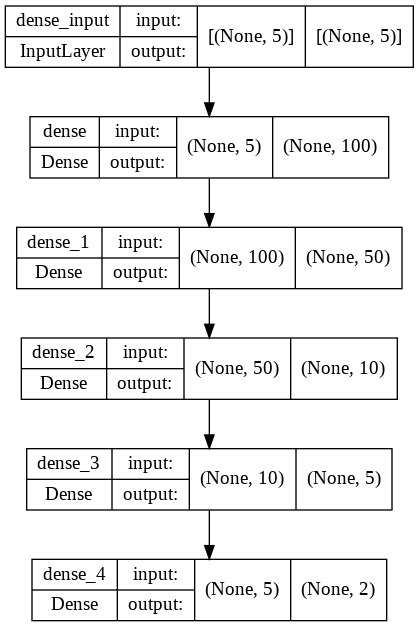

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Compile the model
model.compile(optimizer='SGD', 
              loss='binary_crossentropy', 
              metrics=[keras.metrics.AUC(curve = "PR")])

In [ ]:
modelo = model.fit(x_treino_normalizado,y_treino,batch_size = 1,epochs = 20, validation_data= (x_validacao_normalizado,y_validacao))

Epoch 1/20
14320/14320 [==============================] - 41s 3ms/step - loss: 0.3209 - auc: 0.9332 - val_loss: 0.4330 - val_auc: 0.9275
Epoch 2/20
14320/14320 [==============================] - 37s 3ms/step - loss: 0.3222 - auc: 0.9324 - val_loss: 0.3821 - val_auc: 0.9251
Epoch 3/20
14320/14320 [==============================] - 38s 3ms/step - loss: 0.3218 - auc: 0.9325 - val_loss: 0.3566 - val_auc: 0.9363
Epoch 4/20
14320/14320 [==============================] - 37s 3ms/step - loss: 0.3191 - auc: 0.9335 - val_loss: 0.3336 - val_auc: 0.9337
Epoch 5/20
14320/14320 [==============================] - 38s 3ms/step - loss: 0.3198 - auc: 0.9330 - val_loss: 0.3576 - val_auc: 0.9346
Epoch 6/20
14320/14320 [==============================] - 37s 3ms/step - loss: 0.3184 - auc: 0.9334 - val_loss: 0.3510 - val_auc: 0.9312
Epoch 7/20
14320/14320 [==============================] - 36s 3ms/step - loss: 0.3173 - auc: 0.9348 - val_loss: 0.3418 - val_auc: 0.9282
Epoch 8/20
14320/14320 [=================

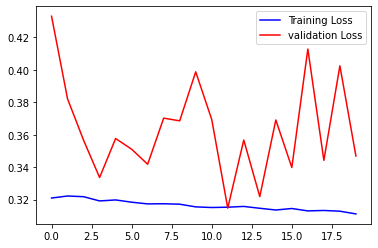

In [ ]:
plt.plot(modelo.history['loss'], color='b', label="Training Loss")
plt.plot(modelo.history['val_loss'], color='r', label="validation Loss")
plt.rcParams['figure.figsize'] = (20, 10)
plt.legend()
plt.show()

In [ ]:
# Testa
score = model.evaluate(x_validacao_normalizado, y_validacao, verbose=0)
print('Test PR AUC:', score[1])

Test PR AUC: 0.9436378479003906


Devido a complexidade do modelo sugerido, o ajuste do modelo ficou demorado e seus resultados na base de teste foram satisfatórios, no entanto, queremos um modelo mais simples que possa ter resultados parecidos.

## 2º Arquitetura (tentando simplificar a rede e o ajuste)

* 5 nós na primeira camada (entradas) 
* **50 nós na primeira camada profunda**
* **10 nós na segunda camadas profunda**
* 2 nós camada de saída (true ou false)
* batch de tamanho 5
* 200 épocas
* **com normalização das bases**

In [ ]:
model = Sequential()
model.add(Dense(50, activation='relu', input_dim=5))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

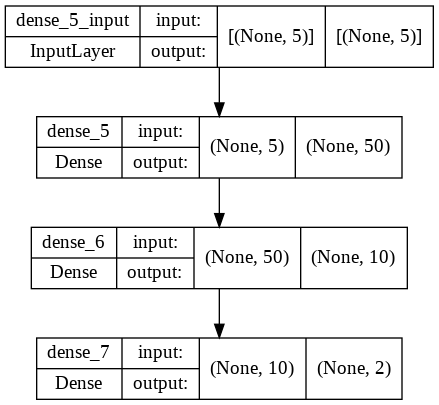

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 50)                300       
                                                                 
 dense_6 (Dense)             (None, 10)                510       
                                                                 
 dense_7 (Dense)             (None, 2)                 22        
                                                                 
Total params: 832
Trainable params: 832
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(optimizer='SGD', 
              loss='binary_crossentropy', 
              metrics=[keras.metrics.AUC(curve = "PR")])

In [ ]:
modelo = model.fit(x_treino_normalizado,y_treino,batch_size = 5, epochs = 200, validation_data= (x_validacao_normalizado,y_validacao))

Epoch 1/200
2864/2864 [==============================] - 10s 3ms/step - loss: 0.6287 - auc_1: 0.7720 - val_loss: 0.5102 - val_auc_1: 0.8748
Epoch 2/200
2864/2864 [==============================] - 8s 3ms/step - loss: 0.4634 - auc_1: 0.8735 - val_loss: 0.4208 - val_auc_1: 0.8956
Epoch 3/200
2864/2864 [==============================] - 7s 3ms/step - loss: 0.3938 - auc_1: 0.9020 - val_loss: 0.4249 - val_auc_1: 0.8967
Epoch 4/200
2864/2864 [==============================] - 8s 3ms/step - loss: 0.3675 - auc_1: 0.9121 - val_loss: 0.4159 - val_auc_1: 0.9030
Epoch 5/200
2864/2864 [==============================] - 8s 3ms/step - loss: 0.3565 - auc_1: 0.9168 - val_loss: 0.4084 - val_auc_1: 0.9057
Epoch 6/200
2864/2864 [==============================] - 8s 3ms/step - loss: 0.3486 - auc_1: 0.9201 - val_loss: 0.3424 - val_auc_1: 0.9310
Epoch 7/200
2864/2864 [==============================] - 8s 3ms/step - loss: 0.3439 - auc_1: 0.9224 - val_loss: 0.3812 - val_auc_1: 0.9163
Epoch 8/200
2864/2864 [===

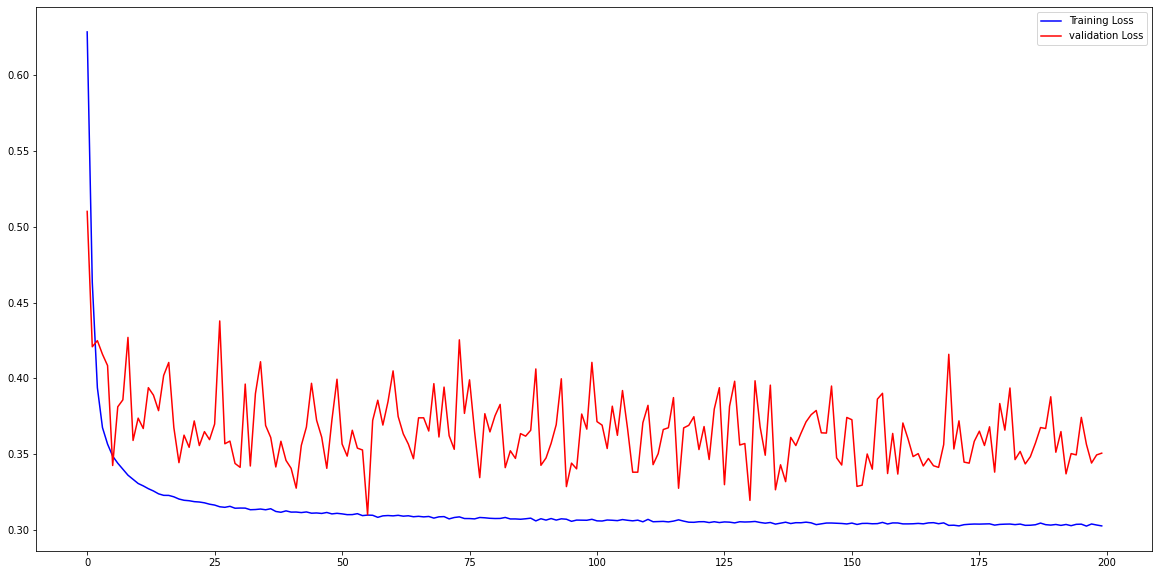

In [ ]:
plt.plot(modelo.history['loss'], color='b', label="Training Loss")
plt.plot(modelo.history['val_loss'], color='r', label="validation Loss")
plt.rcParams['figure.figsize'] = (20, 10)
plt.legend()
plt.show()

In [ ]:
# Testa
score = model.evaluate(x_validacao_normalizado, y_validacao, verbose=0)
print('Test PR AUC:', score[1])

Test PR AUC: 0.936489999294281


O modelo simplificado apresentou um bom resultado para o ajuste da rede, iremos novamente reduzir o tamanho da rede buscando um ajuste de qualidade próxima ao anterior.

## 3º Arquitetura (tentando simplificar a rede e o ajuste) 

* 5 nós na primeira camada (entradas) 
* **5 nós na primeira camada profunda**
* 2 nós camada de saída (true ou false)
* batch de tamanho 5
* 500 épocas
* **com normalização das bases**

In [ ]:
model = Sequential()
model.add(Dense(5, activation='relu', input_dim=5))
model.add(Dense(2, activation='sigmoid'))

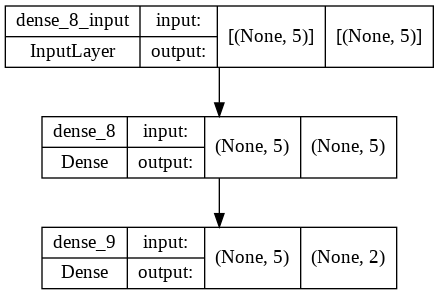

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 5)                 30        
                                                                 
 dense_9 (Dense)             (None, 2)                 12        
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(optimizer="SGD", 
              loss='binary_crossentropy', 
              metrics=[keras.metrics.AUC(curve = "PR")])

In [ ]:
modelo = model.fit(x_treino_normalizado,y_treino,batch_size = 5, epochs = 200, validation_data= (x_validacao_normalizado,y_validacao))

Epoch 1/200
2864/2864 [==============================] - 9s 3ms/step - loss: 0.6695 - auc_2: 0.6856 - val_loss: 0.6310 - val_auc_2: 0.8508
Epoch 2/200
2864/2864 [==============================] - 7s 2ms/step - loss: 0.5941 - auc_2: 0.8381 - val_loss: 0.5385 - val_auc_2: 0.8668
Epoch 3/200
2864/2864 [==============================] - 7s 2ms/step - loss: 0.5176 - auc_2: 0.8709 - val_loss: 0.4679 - val_auc_2: 0.8824
Epoch 4/200
2864/2864 [==============================] - 7s 3ms/step - loss: 0.4647 - auc_2: 0.8819 - val_loss: 0.4603 - val_auc_2: 0.8752
Epoch 5/200
2864/2864 [==============================] - 7s 2ms/step - loss: 0.4337 - auc_2: 0.8906 - val_loss: 0.4467 - val_auc_2: 0.8810
Epoch 6/200
2864/2864 [==============================] - 7s 3ms/step - loss: 0.4133 - auc_2: 0.8974 - val_loss: 0.4435 - val_auc_2: 0.8825
Epoch 7/200
2864/2864 [==============================] - 7s 3ms/step - loss: 0.3987 - auc_2: 0.9031 - val_loss: 0.4090 - val_auc_2: 0.9005
Epoch 8/200
2864/2864 [====

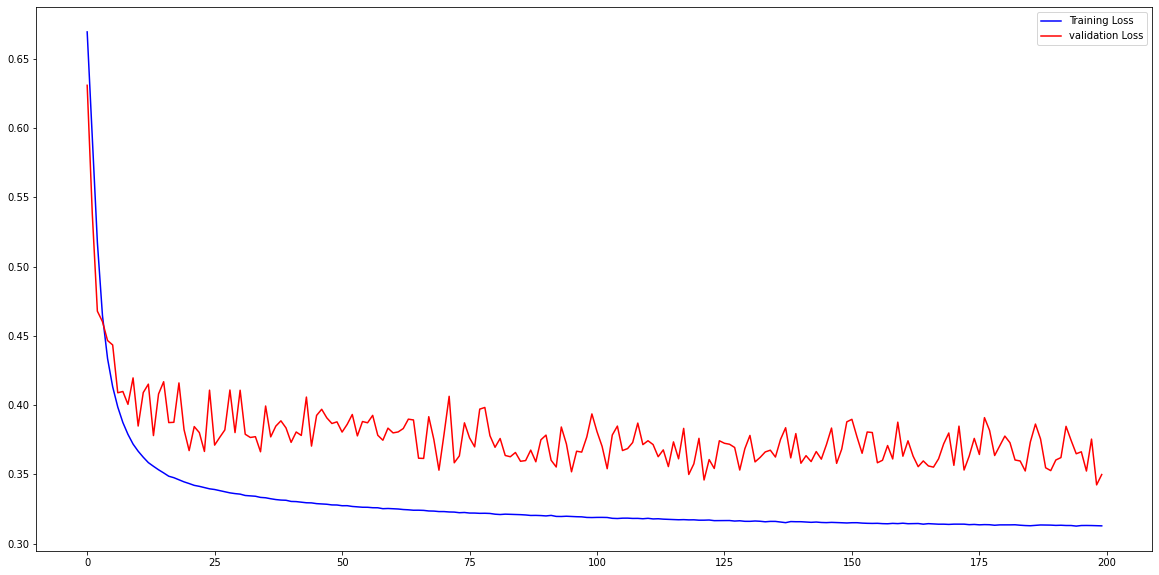

In [ ]:
plt.plot(modelo.history['loss'], color='b', label="Training Loss")
plt.plot(modelo.history['val_loss'], color='r', label="validation Loss")
plt.rcParams['figure.figsize'] = (20, 10)
plt.legend()
plt.show()

In [ ]:
# Testa
score = model.evaluate(x_validacao_normalizado, y_validacao, verbose=0)
print('Test PR AUC:', score[1])

Test PR AUC: 0.9376857876777649


## 4º Arquitetura aplicação do momentum no modelo

* 5 nós na primeira camada (entradas) 
* **5 nós na primeira camada profunda**
* 2 nós camada de saída (true ou false)
* batch de tamanho 10
* 500 épocas
* **com normalização das bases**
* **com momentum**

aumentamos o tamanho do batch por que batchs pequenos com momentum estava tornando os resultados muito instáveis.

In [ ]:
model = Sequential()
model.add(Dense(5, activation='relu', input_dim=5))
model.add(Dense(2, activation='sigmoid'))

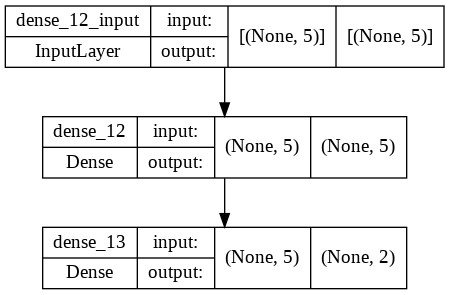

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 5)                 30        
                                                                 
 dense_13 (Dense)            (None, 2)                 12        
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# configuracao do momentum
sgd = keras.optimizers.SGD(momentum=0.9)

In [ ]:
# Compile the model
model.compile(optimizer=sgd, 
              loss='binary_crossentropy', 
              metrics=[keras.metrics.AUC(curve = "PR")])

In [ ]:
modelo = model.fit(x_treino_normalizado,y_treino,batch_size = 10, epochs = 500, validation_data= (x_validacao_normalizado,y_validacao))

Epoch 1/500
1432/1432 [==============================] - 5s 3ms/step - loss: 0.5765 - auc_4: 0.8012 - val_loss: 0.4495 - val_auc_4: 0.8545
Epoch 2/500
1432/1432 [==============================] - 4s 3ms/step - loss: 0.4511 - auc_4: 0.8625 - val_loss: 0.5603 - val_auc_4: 0.7932
Epoch 3/500
1432/1432 [==============================] - 4s 2ms/step - loss: 0.4415 - auc_4: 0.8679 - val_loss: 0.4621 - val_auc_4: 0.8607
Epoch 4/500
1432/1432 [==============================] - 4s 2ms/step - loss: 0.4406 - auc_4: 0.8693 - val_loss: 0.5390 - val_auc_4: 0.8174
Epoch 5/500
1432/1432 [==============================] - 4s 3ms/step - loss: 0.4395 - auc_4: 0.8706 - val_loss: 0.4906 - val_auc_4: 0.8470
Epoch 6/500
1432/1432 [==============================] - 4s 3ms/step - loss: 0.4378 - auc_4: 0.8730 - val_loss: 0.4638 - val_auc_4: 0.8654
Epoch 7/500
1432/1432 [==============================] - 4s 3ms/step - loss: 0.4362 - auc_4: 0.8749 - val_loss: 0.4410 - val_auc_4: 0.8819
Epoch 8/500
1432/1432 [====

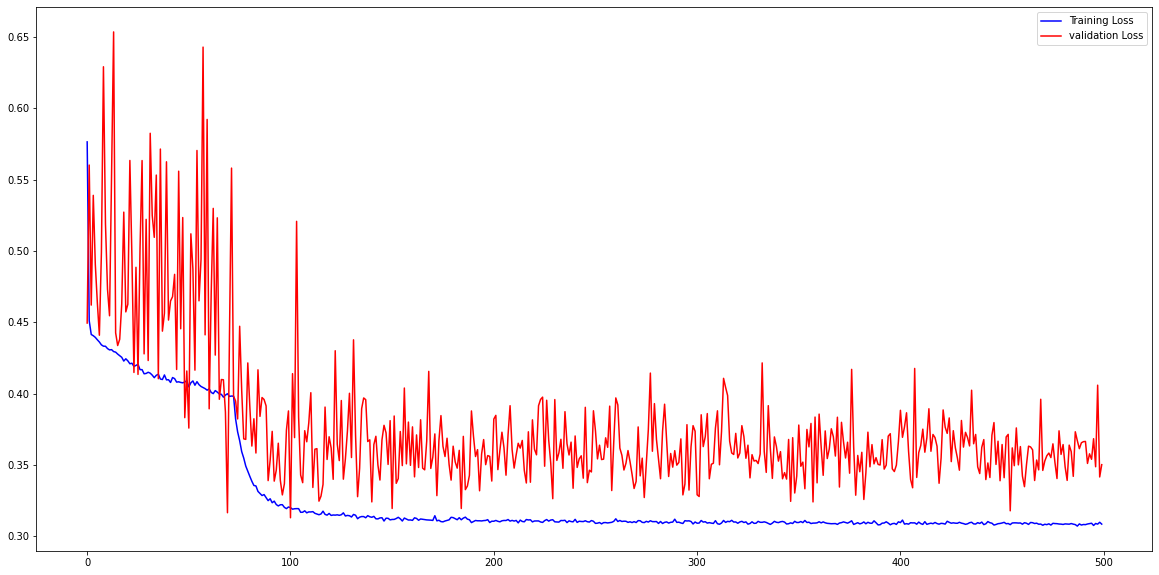

In [ ]:
plt.plot(modelo.history['loss'], color='b', label="Training Loss")
plt.plot(modelo.history['val_loss'], color='r', label="validation Loss")
plt.rcParams['figure.figsize'] = (20, 10)
plt.legend()
plt.show()

In [ ]:
# Testa
score = model.evaluate(x_validacao_normalizado, y_validacao, verbose=0)
print('Test PR AUC:', score[1])

Test PR AUC: 0.9395827054977417


## 5º Arquitetura com aplicação da regularização 

* 5 nós na primeira camada (entradas) 
* **2 nós na primeira camada profunda**
* regularização em todas as camadas e no bias
* 2 nós camada de saída (true ou false)
* batch de tamanho 10
* 100 épocas
* **com normalização das bases**
* com momentum e normalização l2

In [ ]:
model = Sequential()
model.add(Dense(5,input_dim = 5, activation = "relu",kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(Dense(2,activation = "sigmoid"))

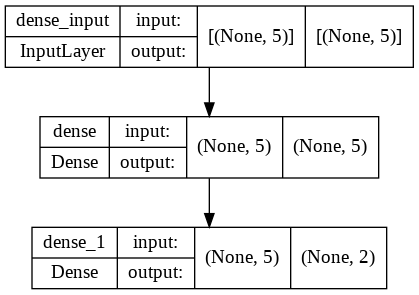

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 30        
                                                                 
 dense_1 (Dense)             (None, 2)                 12        
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# configuracao do momentum
sgd = keras.optimizers.SGD(momentum=0.9)

In [ ]:
# Compile the model
model.compile(optimizer=sgd, 
              loss='binary_crossentropy', 
              metrics=[keras.metrics.AUC(curve = "PR")])

In [ ]:
modelo = model.fit(x_treino_normalizado,y_treino,batch_size = 10, epochs = 100, validation_data= (x_validacao_normalizado,y_validacao))

Epoch 1/100
1432/1432 [==============================] - 4s 2ms/step - loss: 0.6953 - auc: 0.6785 - val_loss: 0.6506 - val_auc: 0.8830
Epoch 2/100
1432/1432 [==============================] - 3s 2ms/step - loss: 0.6653 - auc: 0.7399 - val_loss: 0.6806 - val_auc: 0.6805
Epoch 3/100
1432/1432 [==============================] - 5s 3ms/step - loss: 0.6395 - auc: 0.7834 - val_loss: 0.6584 - val_auc: 0.7347
Epoch 4/100
1432/1432 [==============================] - 8s 6ms/step - loss: 0.6209 - auc: 0.8021 - val_loss: 0.7190 - val_auc: 0.6243
Epoch 5/100
1432/1432 [==============================] - 3s 2ms/step - loss: 0.6104 - auc: 0.8064 - val_loss: 0.5075 - val_auc: 0.9141
Epoch 6/100
1432/1432 [==============================] - 3s 2ms/step - loss: 0.6023 - auc: 0.8093 - val_loss: 0.4745 - val_auc: 0.9256
Epoch 7/100
1432/1432 [==============================] - 3s 2ms/step - loss: 0.5955 - auc: 0.8143 - val_loss: 0.7166 - val_auc: 0.6646
Epoch 8/100
1432/1432 [==============================] 

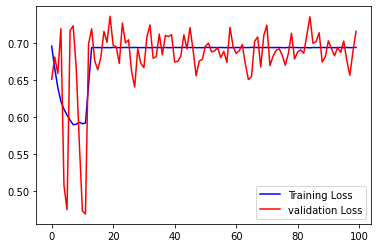

In [ ]:
plt.plot(modelo.history['loss'], color='b', label="Training Loss")
plt.plot(modelo.history['val_loss'], color='r', label="validation Loss")
plt.rcParams['figure.figsize'] = (20, 10)
plt.legend()
plt.show()

In [ ]:
# Testa
score = model.evaluate(x_validacao_normalizado, y_validacao, verbose=0)
print('Test PR AUC:', score[1])

Test PR AUC: 0.32040417194366455


Notamos que com a inclusão de regularização e momentum o modelo ficou instável, possívelmente por regiões de ótimo local próximas o que gerar instabilidades nos parâmetros ajustados. Logo prosseguiremos nossas análises com o modelo da 3º arquitetura sem regularização e momentum no ajuste.

# Modelo Final

* 5 nós na primeira camada (entradas) 
* **5 nós na primeira camada profunda**
* 2 nós camada de saída (true ou false)
* batch de tamanho 5
* 500 épocas
* **com normalização das bases**

In [ ]:
model = Sequential()
model.add(Dense(5, activation='relu', input_dim=5))
model.add(Dense(2, activation='sigmoid'))

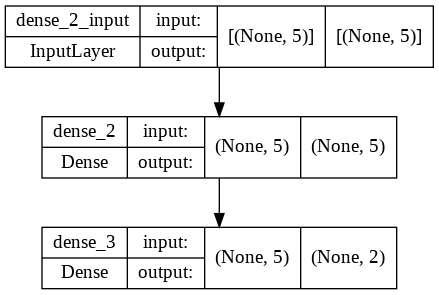

In [ ]:

keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 5)                 30        
                                                                 
 dense_3 (Dense)             (None, 2)                 12        
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(optimizer="SGD", 
              loss='binary_crossentropy', 
              metrics=[keras.metrics.AUC(curve = "PR")])

In [ ]:
modelo = model.fit(x_treino_normalizado,y_treino,batch_size = 5, epochs = 200, validation_data= (x_validacao_normalizado,y_validacao))

Epoch 1/200
2864/2864 [==============================] - 7s 2ms/step - loss: 0.6839 - auc_1: 0.6088 - val_loss: 0.6542 - val_auc_1: 0.7217
Epoch 2/200
2864/2864 [==============================] - 7s 2ms/step - loss: 0.6060 - auc_1: 0.8025 - val_loss: 0.5705 - val_auc_1: 0.7576
Epoch 3/200
2864/2864 [==============================] - 7s 2ms/step - loss: 0.5144 - auc_1: 0.8453 - val_loss: 0.5245 - val_auc_1: 0.7819
Epoch 4/200
2864/2864 [==============================] - 7s 2ms/step - loss: 0.4648 - auc_1: 0.8611 - val_loss: 0.4947 - val_auc_1: 0.8181
Epoch 5/200
2864/2864 [==============================] - 6s 2ms/step - loss: 0.4447 - auc_1: 0.8689 - val_loss: 0.4728 - val_auc_1: 0.8475
Epoch 6/200
2864/2864 [==============================] - 6s 2ms/step - loss: 0.4318 - auc_1: 0.8779 - val_loss: 0.4829 - val_auc_1: 0.8547
Epoch 7/200
2864/2864 [==============================] - 6s 2ms/step - loss: 0.4139 - auc_1: 0.8902 - val_loss: 0.4449 - val_auc_1: 0.8833
Epoch 8/200
2864/2864 [====

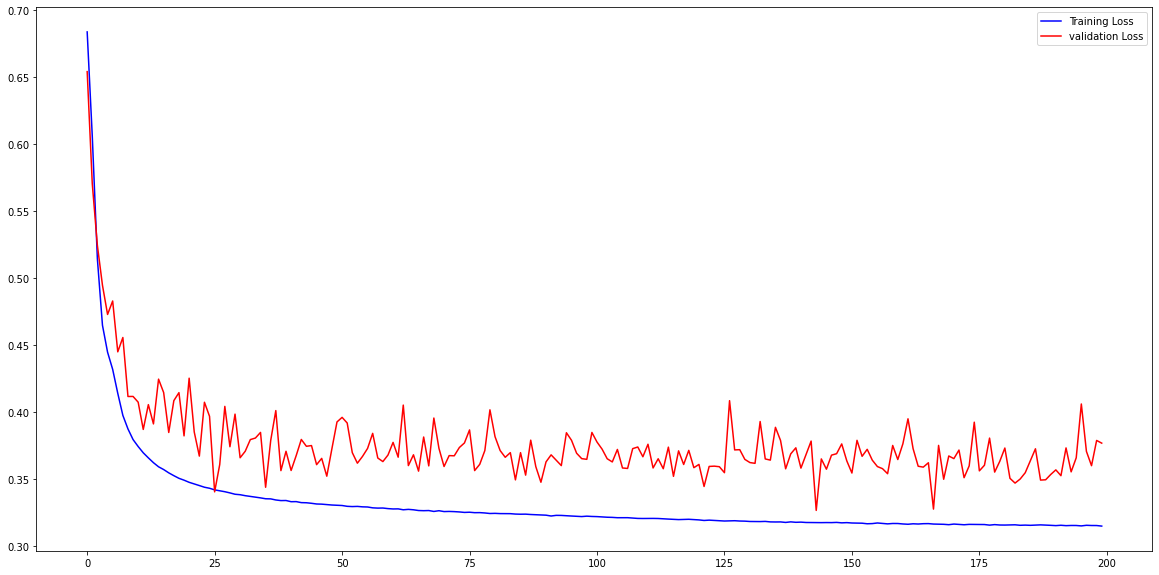

In [ ]:
plt.plot(modelo.history['loss'], color='b', label="Training Loss")
plt.plot(modelo.history['val_loss'], color='r', label="validation Loss")
plt.rcParams['figure.figsize'] = (20, 10)
plt.legend()
plt.show()

In [ ]:
# Testa
score = model.evaluate(x_validacao_normalizado, y_validacao, verbose=0)
print('Test PR AUC:', score[1])

Test PR AUC: 0.9325330257415771


# Regressão

Para o caso de regressão iremos abordar a predição do fluxo crítico de calor ou CHF (*Critical Heat Flux*). Apesar de ser um conjunto de dados pequeno com poucas variáveis e observações, estou estudando o problema da predição do chf no meu mestrado.
Os problemas relacionados à estimação do CHF estão relacionados a transferência de calor, máquina de calor, entre outros.
O CHF pode ser considerado como o limite térmico de um fenomeno onde a ocorrência da mudança de fase durante o aquecimento o que pode gerar uma queda repentina na eficiência da transferência de calor o que pode causar um superaquecimento na superfície aquecida. 
Um exemplo é um tubo sendo e água como líquido refrigerante, ao aquecer o tubo e o mesmo alcançar o limite do chf bolhas começam a se formar ao redor do tubo formando uma "camada" de ar entre o tubo e a água reduzindo a capacidade de transferência do calor do tubo para a água o que causa um superaquecimento que pode derreter o tubo dependendo do material utilizado.
Um exemplo do comportamento do fluxo de calor ao longo da variação da temperatura é apresentado abaixo juntamente com o o ponto **E** representando o momento em que o fluxo apresenta seu limite juntamente com a temperatura:

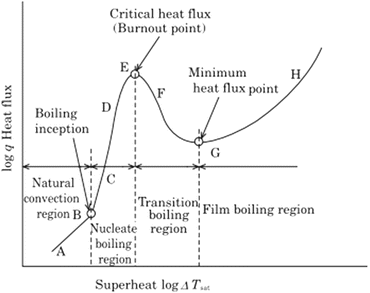



Os dados utilizados é um compilado de vários exprimentos realizados por diferentes autores onde temos observadas diversas variáveis relacionadas aos experimentos realizados.

## Limpeza e Análise Descritiva dos Dados

In [ ]:
dados_chf = pd.read_csv("Data_CHF_Zhao_2020_ATE.csv")

In [ ]:
# realizando a limpeza dos dados iremos remover as informacoes de ID e autor pois estas nao comtribuem para a modelagem

dados_chf.drop(labels = ["id","author"], axis = 1, inplace = True)

In [ ]:
dados_chf.head()

,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


In [ ]:
# renomeando as colunas para formatacao code friendly

dados_chf.columns = ["geometry","pressure","mass_flux","x_e_out","d_e","d_h","lenght","chf_exp"]

In [ ]:
dados_chf.columns.values

array(['geometry', 'pressure', 'mass_flux', 'x_e_out', 'd_e', 'd_h',
       'lenght', 'chf_exp'], dtype=object)

In [ ]:
# iremos aplicar one hot encoding para criar variáveis dummy da variável categórica geometry

dados_chf = pd.get_dummies(dados_chf)

In [ ]:
dados_chf.head()

,pressure,mass_flux,x_e_out,d_e,d_h,lenght,chf_exp,geometry_annulus,geometry_plate,geometry_tube
0,0.39,5600,-0.1041,3.0,3.0,100,11.3,0,0,1
1,0.31,6700,-0.0596,3.0,3.0,100,10.6,0,0,1
2,0.33,4300,-0.0395,3.0,3.0,100,7.3,0,0,1
3,0.62,6400,-0.1460,3.0,3.0,100,12.8,0,0,1
4,0.64,4700,-0.0849,3.0,3.0,100,11.0,0,0,1


In [ ]:
# reorganizar base aleatoriamente para evitar ordenação nao intencional na base do autor

dados_chf = dados_chf.sample(frac=1).reset_index(drop=True)

In [ ]:
dados_chf.shape

(1865, 10)

In [ ]:
# correlação das variáveis
corr = dados_chf.corr()
corr.style.background_gradient(cmap='coolwarm')

,pressure,mass_flux,x_e_out,d_e,d_h,lenght,chf_exp,geometry_annulus,geometry_plate,geometry_tube
pressure,1.000000,-0.165660,-0.296783,-0.400600,-0.514806,-0.190572,-0.356977,-0.192333,-0.366125,0.322270
mass_flux,-0.165660,1.000000,-0.223631,-0.046866,-0.242915,-0.062630,0.453562,-0.204328,-0.151111,0.252654
x_e_out,-0.296783,-0.223631,1.000000,0.110438,0.080584,0.378102,-0.513687,0.266548,-0.072280,-0.227972
d_e,-0.400600,-0.046866,0.110438,1.000000,0.493515,0.373820,-0.082771,0.010215,0.143300,-0.063833
d_h,-0.514806,-0.242915,0.080584,0.493515,1.000000,0.186977,0.099406,0.317849,0.796906,-0.604946
lenght,-0.190572,-0.062630,0.378102,0.373820,0.186977,1.000000,-0.423167,0.644562,-0.201642,-0.541149
chf_exp,-0.356977,0.453562,-0.513687,-0.082771,0.099406,-0.423167,1.000000,-0.239653,0.240145,0.138902
geometry_annulus,-0.192333,-0.204328,0.266548,0.010215,0.317849,0.644562,-0.239653,1.000000,-0.081947,-0.926651
geometry_plate,-0.366125,-0.151111,-0.072280,0.143300,0.796906,-0.201642,0.240145,-0.081947,1.000000,-0.298723
geometry_tube,0.322270,0.252654,-0.227972,-0.063833,-0.604946,-0.541149,0.138902,-0.926651,-0.298723,1.000000


In [ ]:
# separando a base em treino e validação (o keras ja faz separação internamente da base de treino em treino e teste)

entradas = dados_chf.drop(columns=["chf_exp"])
saida = dados_chf.loc[:,"chf_exp"]

x, x_teste, y, y_teste = train_test_split(entradas,saida,test_size=0.1,train_size=0.9)

In [ ]:
# separando base de treino em treino e validacao para aplicação da normalização dos dados
x_treino, x_validacao, y_treino, y_validacao = train_test_split(x,y,test_size = 0.1, train_size = 0.9)



In [ ]:
max_treino = x_treino.max()
min_treino = x_treino.min()

In [ ]:
x_treino_normalizado = (x_treino-min_treino)/(max_treino-min_treino)
x_teste_normalizado = (x_teste-min_treino)/(max_treino-min_treino)
x_validacao_normalizado = (x_validacao-min_treino)/(max_treino-min_treino)


In [ ]:
print("tamanho base treino", x_treino.shape)
print("tamanho base de teste",x_teste.shape)
print("tamanho base de validação",x_validacao.shape)


tamanho base treino (1510, 9)
tamanho base de teste (187, 9)
tamanho base de validação (168, 9)


## 1º Arquitetura Modelo Inicial Simples
* 9 nós na primeira camada (entradas)
* 9 nós na primeira camada profunda 
* 1 nó camada de saída
* batch de tamanho 1
* 200 épocas
* (sem uso do momentum e regularização)

In [ ]:
# definição da arquitetura do modelo

model = Sequential()
model.add(Dense(9, input_dim=9, activation= "relu"))
model.add(Dense(1))

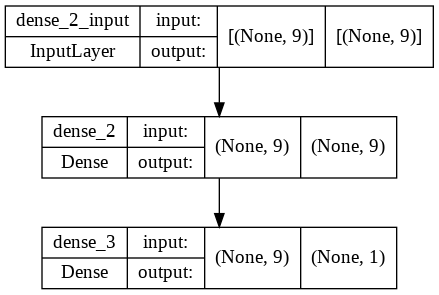

In [ ]:

keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 9)                 90        
                                                                 
 dense_3 (Dense)             (None, 1)                 10        
                                                                 
Total params: 100
Trainable params: 100
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss= "mean_squared_error" , optimizer="SGD", metrics=["mape"])


In [ ]:
modelo = model.fit(x_treino_normalizado,y_treino,batch_size = 1, epochs = 200, validation_data= (x_validacao_normalizado,y_validacao))

Epoch 1/200
1510/1510 [==============================] - 6s 3ms/step - loss: 2.6293 - mape: 33.4828 - val_loss: 1.5099 - val_mape: 31.6560
Epoch 2/200
1510/1510 [==============================] - 2s 2ms/step - loss: 1.4598 - mape: 24.2847 - val_loss: 0.9946 - val_mape: 20.6224
Epoch 3/200
1510/1510 [==============================] - 3s 2ms/step - loss: 1.2449 - mape: 21.8582 - val_loss: 0.8372 - val_mape: 19.4774
Epoch 4/200
1510/1510 [==============================] - 2s 2ms/step - loss: 1.1308 - mape: 21.2618 - val_loss: 0.9688 - val_mape: 20.2303
Epoch 5/200
1510/1510 [==============================] - 2s 2ms/step - loss: 1.1213 - mape: 20.2306 - val_loss: 0.6552 - val_mape: 15.3981
Epoch 6/200
1510/1510 [==============================] - 3s 2ms/step - loss: 1.0894 - mape: 20.1804 - val_loss: 0.7110 - val_mape: 19.0270
Epoch 7/200
1510/1510 [==============================] - 3s 2ms/step - loss: 1.0785 - mape: 20.3580 - val_loss: 0.7726 - val_mape: 21.4975
Epoch 8/200
1510/1510 [====

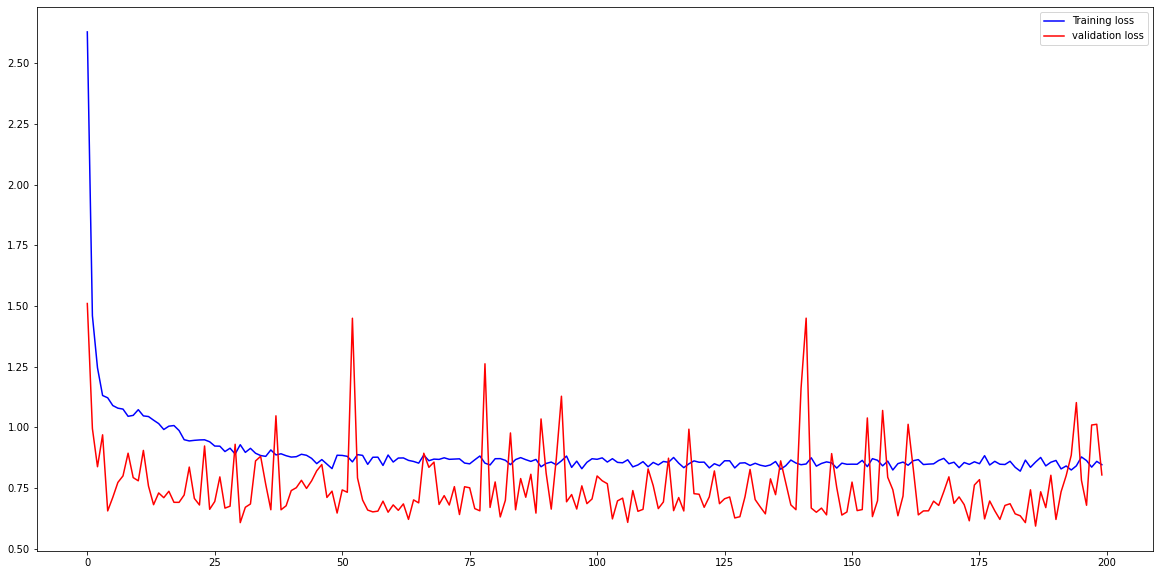

In [ ]:
plt.plot(modelo.history['loss'], color='b', label="Training loss")
plt.plot(modelo.history['val_loss'], color='r', label="validation loss")
plt.rcParams['figure.figsize'] = (20, 10)
plt.legend()
plt.show()


In [ ]:
# Testa
score = model.evaluate(x_teste_normalizado, y_teste, verbose=0)
print('Mape Test loss:', score[1])

Mape Test loss: 16.26662826538086


## 2º Arquitetura com maior complexidade e épocas
* 9 nós na primeira camada (entradas)
* **9 nós na camada intermediária**
* 1 nó camada de saída
* batch de tamanho 5
* 500 épocas
* (sem uso do momentum e regularização)


Iremos aumentar a complexidade do modelo para verificar se o aumento traz melhorias significativas nos resultados do ajuste com mais épocas

In [ ]:
# definição da arquitetura do modelo
model = Sequential()
model.add(Dense(9, input_dim=9, activation= "relu"))
model.add(Dense(3,activation = "relu"))
model.add(Dense(1))

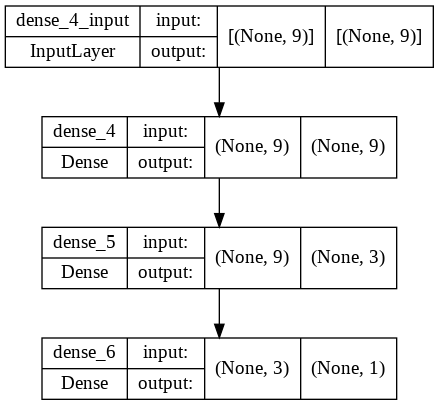

In [ ]:

keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 9)                 90        
                                                                 
 dense_5 (Dense)             (None, 3)                 30        
                                                                 
 dense_6 (Dense)             (None, 1)                 4         
                                                                 
Total params: 124
Trainable params: 124
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss= "mean_squared_error" , optimizer="SGD", metrics=["mape"])

In [ ]:
modelo = model.fit(x_treino_normalizado,y_treino,batch_size = 1, epochs = 500, validation_data= (x_validacao_normalizado,y_validacao))

Epoch 1/500
1510/1510 [==============================] - 3s 2ms/step - loss: 3.4028 - mape: 38.5826 - val_loss: 3.9432 - val_mape: 50.8382
Epoch 2/500
1510/1510 [==============================] - 2s 1ms/step - loss: 4.1606 - mape: 48.7847 - val_loss: 3.9160 - val_mape: 54.7485
Epoch 3/500
1510/1510 [==============================] - 3s 2ms/step - loss: 4.1617 - mape: 48.9049 - val_loss: 3.8164 - val_mape: 48.4694
Epoch 4/500
1510/1510 [==============================] - 2s 1ms/step - loss: 4.1450 - mape: 48.5034 - val_loss: 3.8204 - val_mape: 50.4768
Epoch 5/500
1510/1510 [==============================] - 2s 1ms/step - loss: 4.1464 - mape: 48.7244 - val_loss: 3.7982 - val_mape: 47.5268
Epoch 6/500
1510/1510 [==============================] - 2s 2ms/step - loss: 4.1387 - mape: 48.3681 - val_loss: 3.7605 - val_mape: 47.9098
Epoch 7/500
1510/1510 [==============================] - 2s 2ms/step - loss: 4.1333 - mape: 48.4041 - val_loss: 3.7160 - val_mape: 48.0095
Epoch 8/500
1510/1510 [====

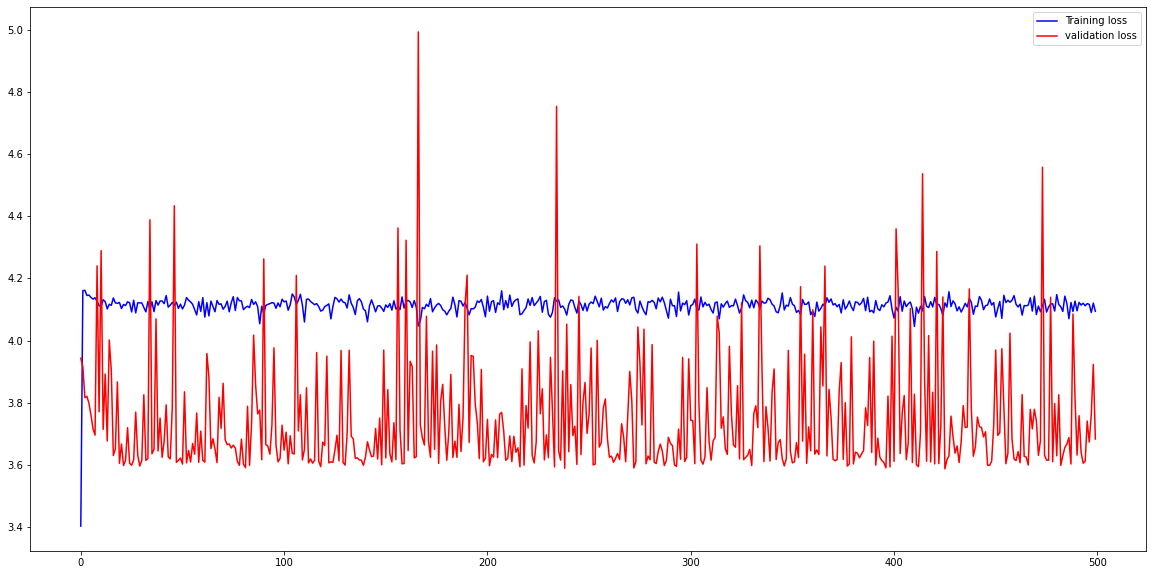

In [ ]:
plt.plot(modelo.history['loss'], color='b', label="Training loss")
plt.plot(modelo.history['val_loss'], color='r', label="validation loss")
plt.rcParams['figure.figsize'] = (20, 10)
plt.legend()
plt.show()


In [ ]:
# Testa
score = model.evaluate(x_teste_normalizado, y_teste, verbose=0)
print('Mape Test loss:', score[1])

Mape Test loss: 35.023319244384766


podemos notar que o modelo mesmo que mais complexo acabou não resultando em um melhor ajuste, iremos novamente simplificar o modelo mas neste caso iremos remover a variáveis categorica de tipo de "tubo" e iremos aplicar um modelo inicial novamente.

## 3º Arquitetura modelo simples sem as variáveis categóricas
* 6 nós na primeira camada (entradas) - **foram removidas as dummy da variável categorica**
* 1 nó camada de saída
* batch de tamanho 1
* 200 épocas
* (sem uso do momentum e regularização)


In [ ]:
x_treino_normalizado_semdummy =  x_treino_normalizado.drop(columns = [ "geometry_annulus","geometry_plate","geometry_tube"])
x_teste_normalizado_semdummy = x_teste_normalizado.drop(columns = [ "geometry_annulus","geometry_plate","geometry_tube"])
x_validacao_normalizado_semdummy = x_validacao_normalizado.drop(columns = [ "geometry_annulus","geometry_plate","geometry_tube"])


In [ ]:
# definição da arquitetura do modelo
model = Sequential()
model.add(Dense(6, input_dim=6, activation= "relu"))
model.add(Dense(1))

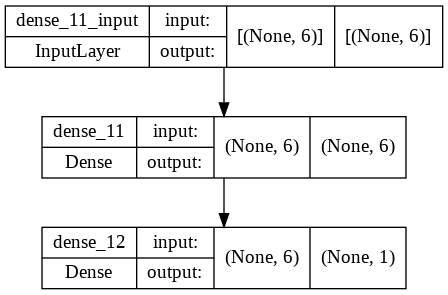

In [ ]:

keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 6)                 42        
                                                                 
 dense_12 (Dense)            (None, 1)                 7         
                                                                 
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss= "mean_squared_error" , optimizer="SGD", metrics=["mape"])

In [ ]:
modelo = model.fit(x_treino_normalizado_semdummy,y_treino,batch_size = 1, epochs = 500, validation_data= (x_validacao_normalizado_semdummy,y_validacao))

Epoch 1/500
1510/1510 [==============================] - 4s 2ms/step - loss: 2.5958 - mape: 33.7342 - val_loss: 1.1812 - val_mape: 22.5266
Epoch 2/500
1510/1510 [==============================] - 2s 2ms/step - loss: 1.4675 - mape: 24.0361 - val_loss: 0.8709 - val_mape: 22.4771
Epoch 3/500
1510/1510 [==============================] - 2s 1ms/step - loss: 1.2278 - mape: 21.8505 - val_loss: 0.9886 - val_mape: 17.0284
Epoch 4/500
1510/1510 [==============================] - 2s 1ms/step - loss: 1.1261 - mape: 20.8248 - val_loss: 0.8056 - val_mape: 17.9476
Epoch 5/500
1510/1510 [==============================] - 2s 1ms/step - loss: 1.0808 - mape: 20.0330 - val_loss: 0.8741 - val_mape: 16.9084
Epoch 6/500
1510/1510 [==============================] - 2s 1ms/step - loss: 1.0666 - mape: 20.1688 - val_loss: 0.7948 - val_mape: 18.2944
Epoch 7/500
1510/1510 [==============================] - 2s 1ms/step - loss: 1.0148 - mape: 19.8107 - val_loss: 0.8011 - val_mape: 19.3555
Epoch 8/500
1510/1510 [====

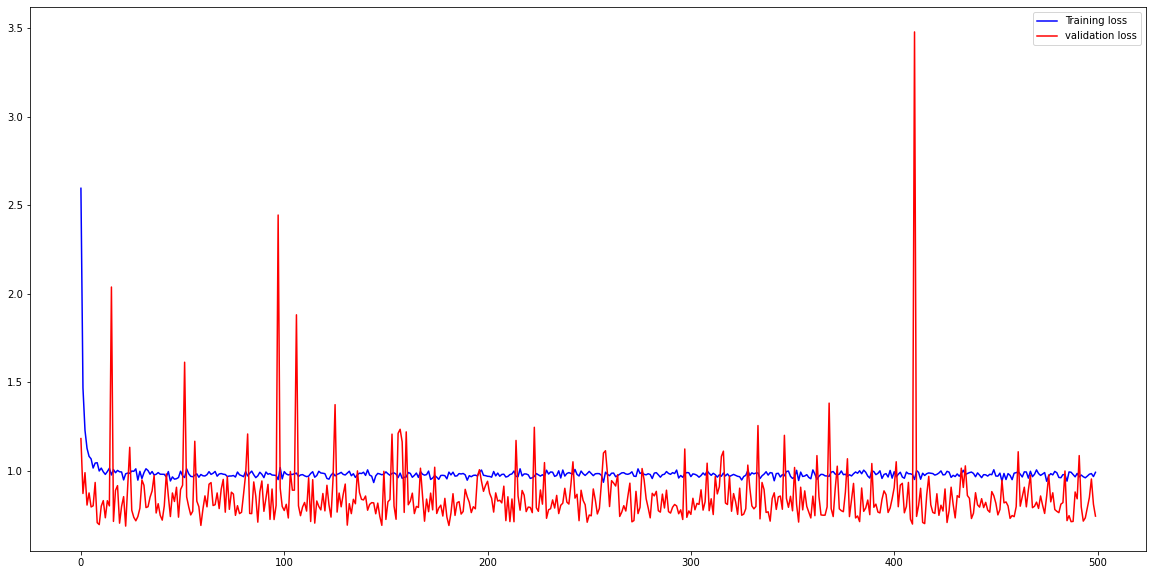

In [ ]:
plt.plot(modelo.history['loss'], color='b', label="Training loss")
plt.plot(modelo.history['val_loss'], color='r', label="validation loss")
plt.rcParams['figure.figsize'] = (20, 10)
plt.legend()
plt.show()


In [ ]:
# Testa
score = model.evaluate(x_teste_normalizado_semdummy, y_teste, verbose=0)
print('Mape Test loss:', score[1])

Mape Test loss: 15.144474983215332


## 4º Arquitetura Aplicação da regularização
* 6 nós na primeira camada (entradas) - **foram removidas as dummy da variável categorica**
* **6 nós na primeira camada profunda**
* 1 nó camada de saída
* batch de tamanho 1
* 500 épocas
* **com regularização l2**
* **com normalização das bases**

iremos aplicar a regularização com menos épocas para verificação se podemos reduzir a complexidade do modelo com a mesma performance.

In [ ]:
# definição da arquitetura do modelo
model = Sequential()
model.add(Dense(6, input_dim=6, activation= "relu",
                kernel_regularizer=keras.regularizers.l2(0.01),
                bias_regularizer=keras.regularizers.l2(0.01)))
model.add(Dense(1))

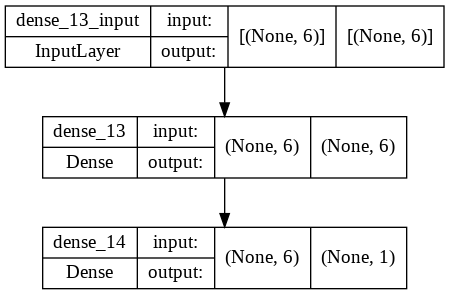

In [ ]:

keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 6)                 42        
                                                                 
 dense_14 (Dense)            (None, 1)                 7         
                                                                 
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss= "mean_squared_error" , optimizer="SGD", metrics=["mape"])

In [ ]:
modelo = model.fit(x_treino_normalizado_semdummy,y_treino,batch_size = 1, epochs = 100, validation_data= (x_validacao_normalizado_semdummy,y_validacao))

Epoch 1/100
1510/1510 [==============================] - 3s 1ms/step - loss: 2.7434 - mape: 33.8997 - val_loss: 1.4469 - val_mape: 26.3540
Epoch 2/100
1510/1510 [==============================] - 2s 1ms/step - loss: 1.8854 - mape: 28.5642 - val_loss: 1.3120 - val_mape: 25.0479
Epoch 3/100
1510/1510 [==============================] - 2s 1ms/step - loss: 1.8451 - mape: 26.9879 - val_loss: 1.4985 - val_mape: 24.2256
Epoch 4/100
1510/1510 [==============================] - 2s 1ms/step - loss: 1.7707 - mape: 26.5246 - val_loss: 1.8179 - val_mape: 25.3303
Epoch 5/100
1510/1510 [==============================] - 2s 1ms/step - loss: 1.7466 - mape: 25.3132 - val_loss: 1.2659 - val_mape: 19.3490
Epoch 6/100
1510/1510 [==============================] - 3s 2ms/step - loss: 1.6279 - mape: 23.7798 - val_loss: 1.6822 - val_mape: 28.5149
Epoch 7/100
1510/1510 [==============================] - 3s 2ms/step - loss: 1.5923 - mape: 22.7998 - val_loss: 1.1557 - val_mape: 22.0247
Epoch 8/100
1510/1510 [====

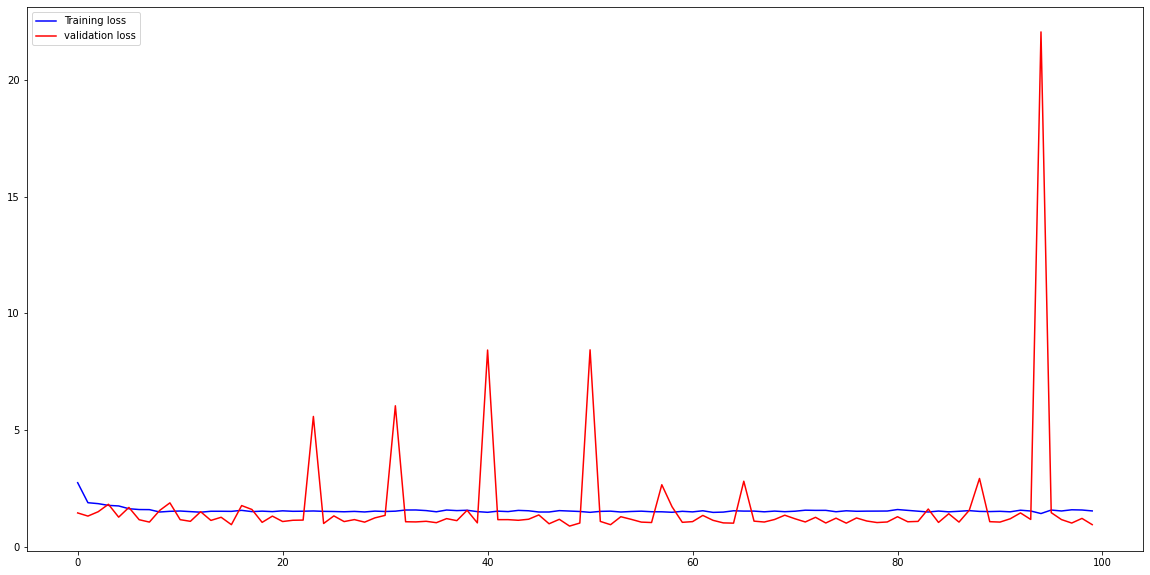

In [ ]:
plt.plot(modelo.history['loss'], color='b', label="Training loss")
plt.plot(modelo.history['val_loss'], color='r', label="validation loss")
plt.rcParams['figure.figsize'] = (20, 10)
plt.legend()
plt.show()


In [ ]:
# Testa
score = model.evaluate(x_teste_normalizado_semdummy, y_teste, verbose=0)
print('Mape Test loss:', score[1])

Mape Test loss: 17.938966751098633


Apesar de uma variabilidade considerável em algumas épocas considera-se um bom resultado no modelo ajustado, iremos verificar quais foram os pesos finais ajustados  e o impacto das variáveis utilizando o método de interpretação de modelos Shapley Values da rede para uma nova simplificação.

In [ ]:
x_treino_normalizado_semdummy.columns

Index(['pressure', 'mass_flux', 'x_e_out', 'd_e', 'd_h', 'lenght'], dtype='object')

In [ ]:
model.weights

[<tf.Variable 'dense_13/kernel:0' shape=(6, 6) dtype=float32, numpy=
 array([[ 1.6908726e+00, -4.8185007e-14,  2.4500439e-15, -3.3973251e-14,
         -2.2640162e-14, -3.3253697e-01],
        [-3.9815360e-01,  1.1905492e-14,  2.4089070e-14,  1.6089420e-14,
         -6.8916595e-15,  1.2609774e+00],
        [ 2.5548413e+00, -9.4240293e-16, -3.4344906e-14, -4.6791266e-14,
          1.3193955e-14, -1.6271579e+00],
        [ 3.0279237e-01,  5.7802197e-15,  2.7662543e-14, -1.3117125e-14,
          4.6772710e-15, -7.7398968e-01],
        [-6.1046869e-01, -4.9145021e-14, -2.8693163e-14, -4.2939614e-14,
         -5.5950751e-14, -6.8808264e-01],
        [ 6.7174220e-01, -2.4403504e-14, -5.0807642e-14, -3.4499527e-14,
          2.8266782e-14, -1.8094075e+00]], dtype=float32)>,
 <tf.Variable 'dense_13/bias:0' shape=(6,) dtype=float32, numpy=
 array([-1.4173220e+00, -1.1048724e-14, -2.9900656e-14,  0.0000000e+00,
        -2.4028387e-14,  1.5179694e+00], dtype=float32)>,
 <tf.Variable 'dense_14/kern

In [ ]:
!pip install -q shap

In [ ]:
import numpy as np
import shap

In [ ]:
explainer = shap.KernelExplainer(model.predict,x_treino_normalizado_semdummy.sample(50))

In [ ]:
shap_values = explainer.shap_values(x_validacao_normalizado_semdummy,nsamples=100)

  0%|          | 0/168 [00:00<?, ?it/s]

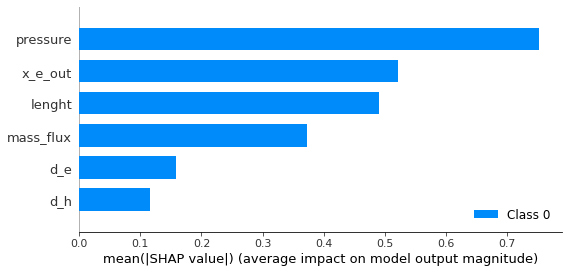

In [ ]:
shap.initjs()
shap.summary_plot(shap_values,x_validacao_normalizado_semdummy)

Analisando os resultados apresentados dos pesos e dos valores shap temos que a variável pressure, x_e_out e length tiveram maior impacto no resultado, além de que muitos nós ficaram com pesos próximos de zero, iremos entao reduzir  o numero de nós na primeira camada para 1 e remover a regularização para verificar o ajuste

## 5º Arquitetura 
* 6 nós na primeira camada (entradas) - **foram colocadas denovo as variáveis dummy**
* **1 nó na primeira camada profunda**
* 1 nó camada de saída
* batch de tamanho 5
* 100 épocas
* **com uso da regularização l2**
* **com normalização das bases**

In [ ]:
# definição da arquitetura do modelo
model = Sequential()
model.add(Dense(1, input_dim=6, activation= "relu"))
model.add(Dense(1))

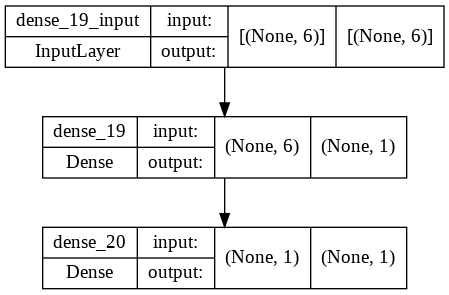

In [ ]:

keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 1)                 7         
                                                                 
 dense_20 (Dense)            (None, 1)                 2         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss= "mean_squared_error" , optimizer="SGD", metrics=["mape"])

In [ ]:
modelo = model.fit(x_treino_normalizado_semdummy,y_treino,batch_size = 1, epochs = 100, validation_data= (x_validacao_normalizado_semdummy,y_validacao))

Epoch 1/100
1510/1510 [==============================] - 2s 1ms/step - loss: 2.5064 - mape: 33.3804 - val_loss: 1.2527 - val_mape: 28.2124
Epoch 2/100
1510/1510 [==============================] - 2s 1ms/step - loss: 1.5419 - mape: 27.8369 - val_loss: 0.9900 - val_mape: 24.2543
Epoch 3/100
1510/1510 [==============================] - 2s 1ms/step - loss: 1.3946 - mape: 26.0652 - val_loss: 1.1909 - val_mape: 28.5712
Epoch 4/100
1510/1510 [==============================] - 2s 1ms/step - loss: 1.3326 - mape: 25.9418 - val_loss: 0.9277 - val_mape: 23.8485
Epoch 5/100
1510/1510 [==============================] - 2s 1ms/step - loss: 1.3226 - mape: 25.5457 - val_loss: 1.0429 - val_mape: 27.6010
Epoch 6/100
1510/1510 [==============================] - 2s 1ms/step - loss: 1.3077 - mape: 25.3330 - val_loss: 1.4174 - val_mape: 30.9856
Epoch 7/100
1510/1510 [==============================] - 2s 1ms/step - loss: 1.3141 - mape: 25.2482 - val_loss: 1.0610 - val_mape: 23.4418
Epoch 8/100
1510/1510 [====

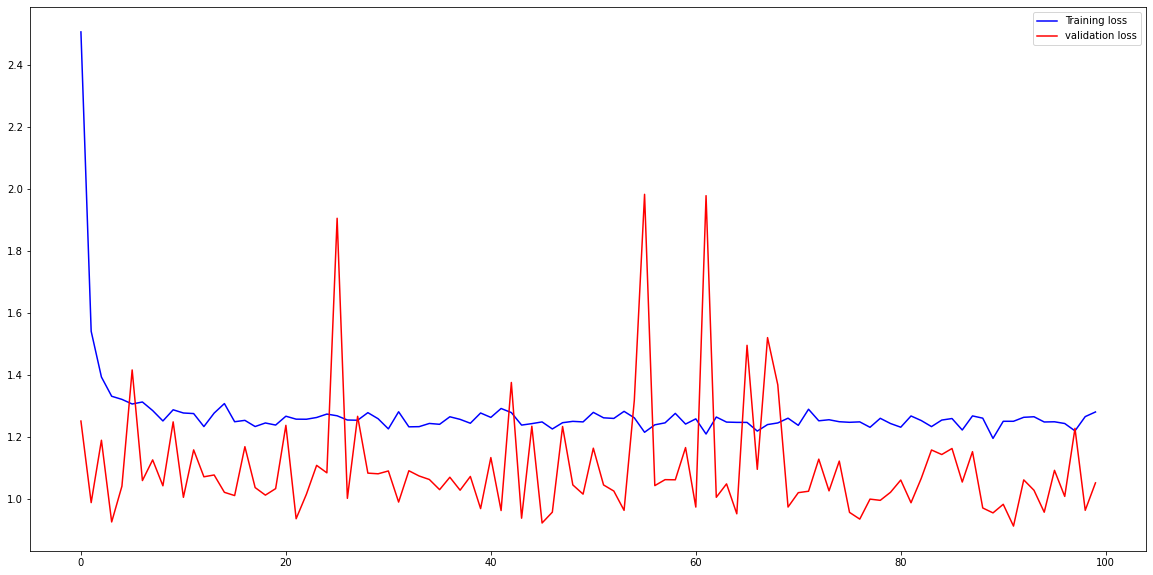

In [ ]:
plt.plot(modelo.history['loss'], color='b', label="Training loss")
plt.plot(modelo.history['val_loss'], color='r', label="validation loss")
plt.rcParams['figure.figsize'] = (20, 10)
plt.legend()
plt.show()


In [ ]:
# Testa
score = model.evaluate(x_teste_normalizado_semdummy, y_teste, verbose=0)
print('Mape Test loss:', score[1])

Mape Test loss: 20.139087677001953


In [ ]:
explainer = shap.KernelExplainer(model.predict,x_treino_normalizado_semdummy.sample(100))

In [ ]:
shap_values = explainer.shap_values(x_validacao_normalizado_semdummy,nsamples=100)

  0%|          | 0/168 [00:00<?, ?it/s]

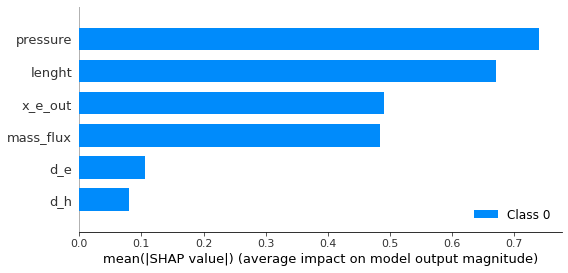

In [ ]:
shap.initjs()
shap.summary_plot(shap_values,x_validacao_normalizado_semdummy)

In [ ]:
model.weights

[<tf.Variable 'dense_19/kernel:0' shape=(6, 1) dtype=float32, numpy=
 array([[-3.8967245],
        [ 2.3774254],
        [-6.868495 ],
        [-0.931519 ],
        [-1.0425436],
        [-4.943412 ]], dtype=float32)>,
 <tf.Variable 'dense_19/bias:0' shape=(1,) dtype=float32, numpy=array([8.398231], dtype=float32)>,
 <tf.Variable 'dense_20/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[1.9295799]], dtype=float32)>,
 <tf.Variable 'dense_20/bias:0' shape=(1,) dtype=float32, numpy=array([2.4878714], dtype=float32)>]

Neste ultimo modelo com menor complexidade e com  resultado final de MAPE de: 20% de erro podemos considerar um modelo com bom ajuste para o problema dado. Além do mais, pela estrutura do modelo ser simples é possível interpretar os resultados e impactos que cada variáveis apresenta, onde a pressão é o maior influenciador para o calculo do chf o que concorda com a interpretação física do problema.